=== Starting Multi-World Forecasting Experiment ===
Settings: 100 samples, 2 worlds, prefix_len=50, horizon=40

Generating multi-world time series data...
[50, 50]

Training forecasting models...


  3%|█████                                                                                                                                                                     | 30/1000 [00:00<00:06, 143.79it/s]

Epoch 0: NLL = 1.1903


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [00:00<00:02, 310.20it/s]

Epoch 200: NLL = 0.0018


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [00:01<00:01, 312.63it/s]

Epoch 400: NLL = 0.0018


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [00:02<00:01, 257.37it/s]

Epoch 600: NLL = 0.0185


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [00:03<00:00, 282.59it/s]

Epoch 800: NLL = 0.1158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.66it/s]


using device cpu
Preparing training data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 37899.20it/s]
/home/kreffert/Probabilistic_LTSF/notebooks/experiments/multi_world_experiment.py:332: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # [n_samples, input_len, 1]


Training with 1000 samples in batches of 64


 10%|█████████████████▍                                                                                                                                                            | 1/10 [00:16<02:30, 16.73s/it]

Epoch 0 | Avg NLL: 1.1239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.01s/it]



Evaluating models...

=== Model Evaluation Summary ===
Test sample index: 53

Negative Log-Likelihood (NLL) - lower is better:
  DMS         : 0.144
  IMS         : 1.153
  Ground Truth: -0.786

Entropy - measures uncertainty:
  DMS         : 0.014
  IMS         : -0.107
  Ground Truth: -0.557

Generating visualizations...


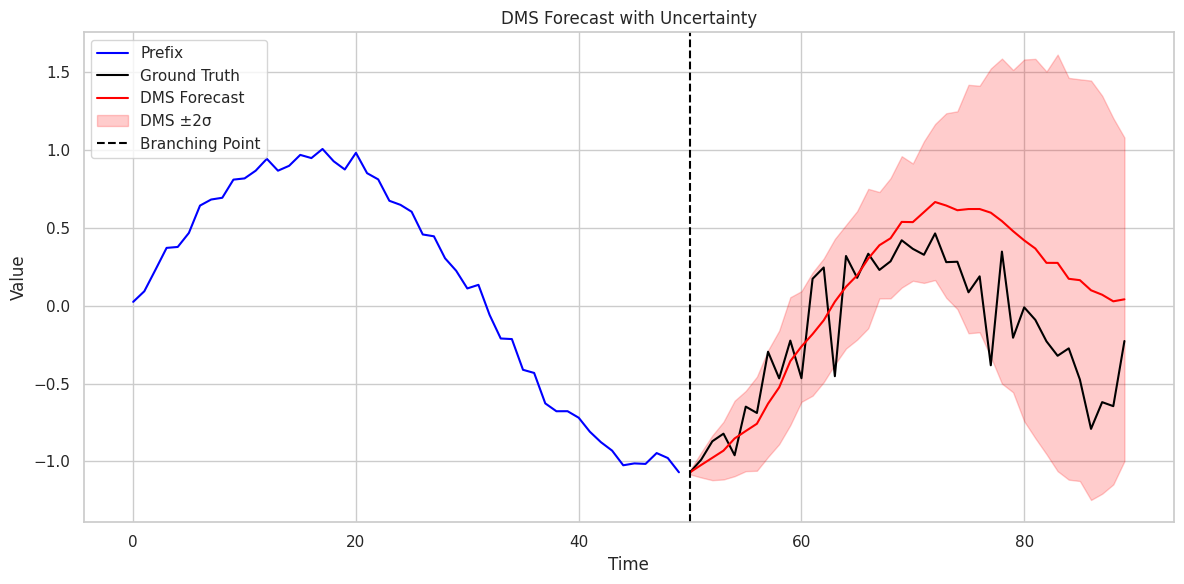

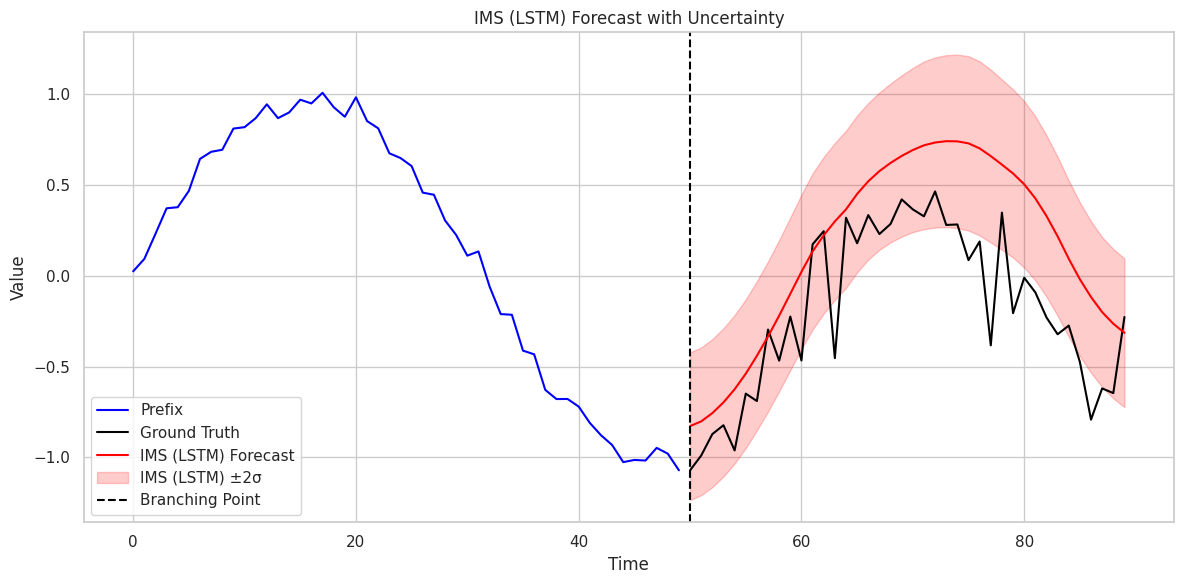

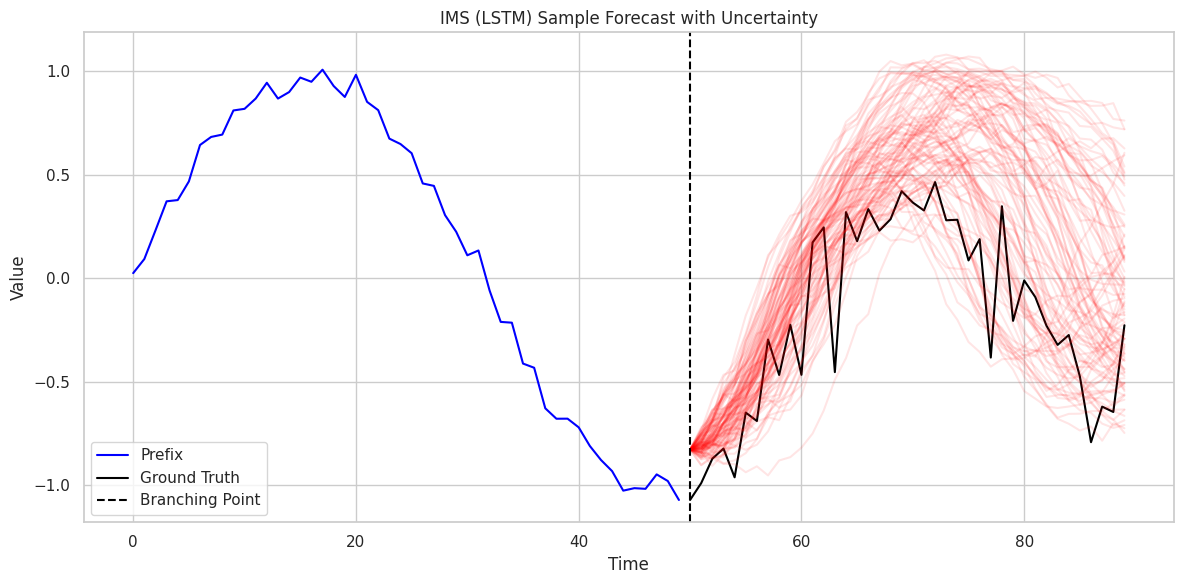

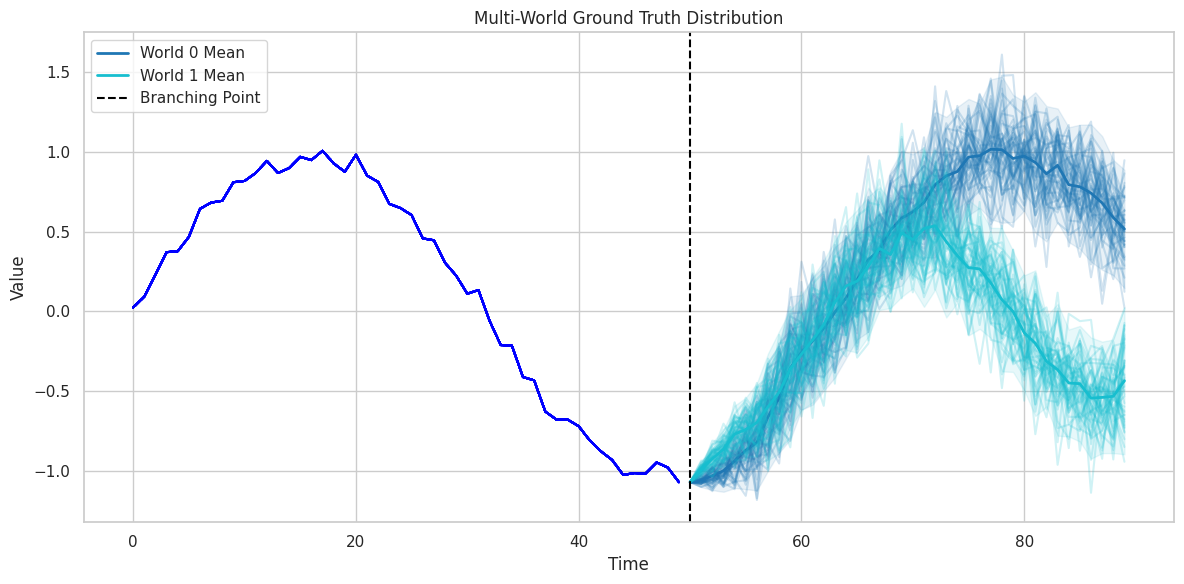

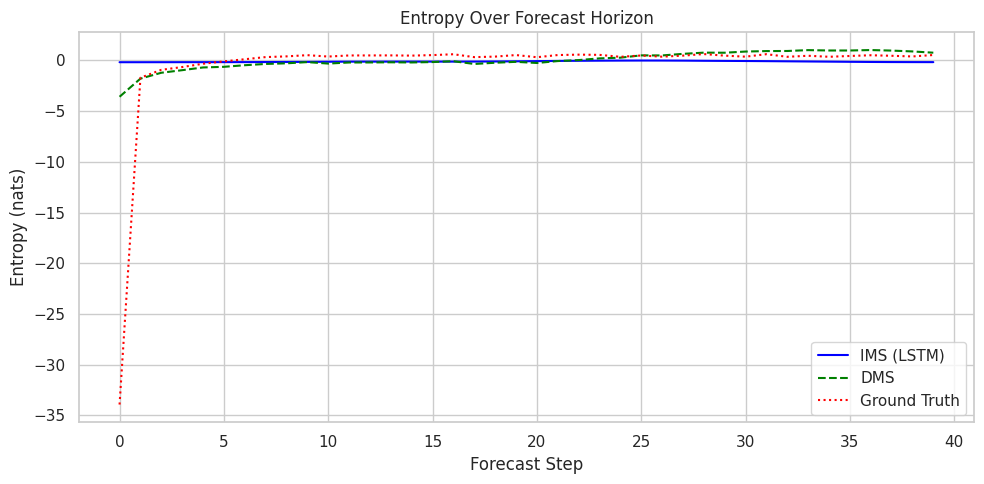

In [1]:
import os
os.chdir('/home/kreffert/Probabilistic_LTSF/notebooks/experiments')
# os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/experiments/')
from multi_world_experiment import MultiWorldExperiment

experiment = MultiWorldExperiment(
    seq_len=100,
    prefix_len=50, 
    forecast_horizon=40
)

results = experiment.run_experiment(
    n_samples=100,
    n_worlds=2,
    dms_epochs=1000,
    ims_epochs=10,
    num_samples_ims=100,
)

In [21]:
samples_ims = results["ims"]["samples"].squeeze(1).numpy()
samples = results['ground_truth']['samples'][:, 60:]

from torch.distributions import Normal
import torch

def compute_dms(results):
    mu = results['dms']['mu']
    sigma = results['dms']['sigma']
    dist = Normal(torch.tensor(mu), torch.tensor(sigma))
    return dist.rsample((100,))

samples_dms = compute_dms(results).numpy()
print(samples_ims.shape, samples.shape, samples_dms.shape)

(100, 40) (100, 40) (100, 40)


In [22]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist
from sklearn.neighbors import KernelDensity
import numpy as np

def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    mmd = xx.mean() + yy.mean() - 2 * xy.mean()
    return mmd

def compute_energy_distance(x, y):
    d_xx = cdist(x, x, metric='euclidean')
    d_yy = cdist(y, y, metric='euclidean')
    d_xy = cdist(x, y, metric='euclidean')
    energy = 2 * d_xy.mean() - d_xx.mean() - d_yy.mean()
    return energy

def compute_kl_kde(samples_p, samples_q, bandwidth=1.0):
    kde_p = KernelDensity(bandwidth=bandwidth).fit(samples_p)
    kde_q = KernelDensity(bandwidth=bandwidth).fit(samples_q)
    log_p = kde_p.score_samples(samples_p)
    log_q = kde_q.score_samples(samples_p)
    return np.mean(log_p - log_q)  # KL(P || Q)

    
mmd = compute_mmd(samples, samples_ims)
energy = compute_energy_distance(samples, samples_ims)
kl = compute_kl_kde(samples, samples_ims)

print(f"MMD: {mmd:.4f}")
print(f"Energy Distance: {energy:.4f}")
print(f"KL Divergence (approx): {kl:.4f}")

mmd = compute_mmd(samples, samples_dms)
energy = compute_energy_distance(samples, samples_dms)
kl = compute_kl_kde(samples, samples_dms)

print(f"MMD: {mmd:.4f}")
print(f"Energy Distance: {energy:.4f}")
print(f"KL Divergence (approx): {kl:.4f}")


MMD: 0.1248
Energy Distance: 2.5411
KL Divergence (approx): 3.3625
MMD: 0.0470
Energy Distance: 3.6251
KL Divergence (approx): 10.2853


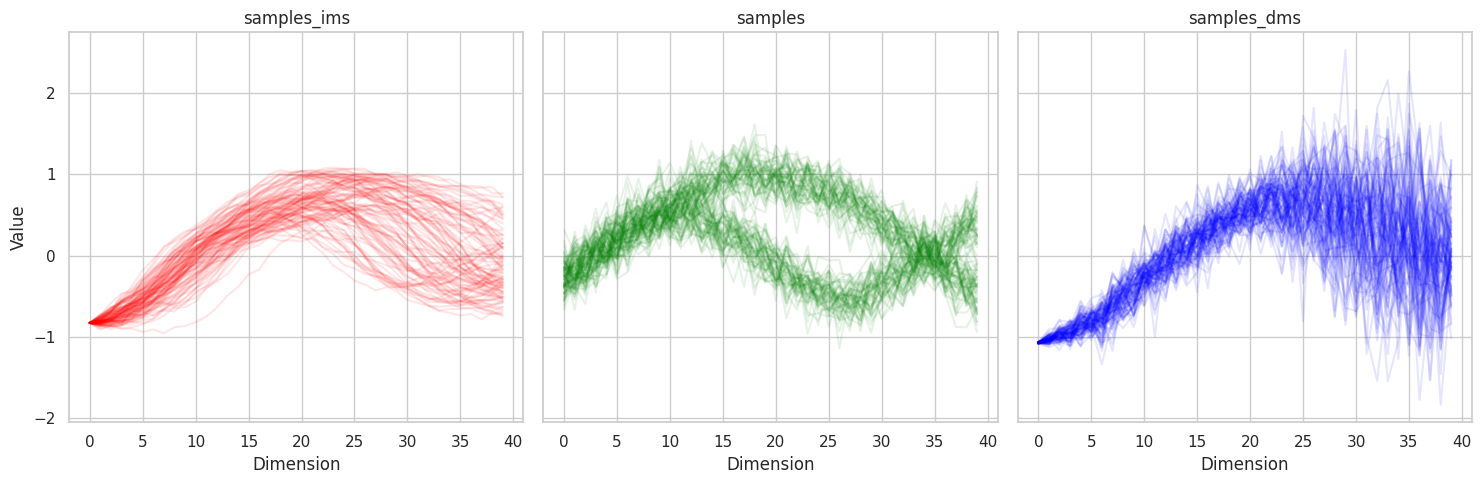

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red lines: samples_ims
for i in range(samples_ims.shape[0]):
    axes[0].plot(range(samples_ims.shape[1]), samples_ims[i, :], color='red', alpha=0.1)
axes[0].set_title('samples_ims')

# Green lines: samples
for i in range(samples.shape[0]):
    axes[1].plot(range(samples.shape[1]), samples[i, :], color='green', alpha=0.1)
axes[1].set_title('samples')

# Blue lines: samples_dms
for i in range(samples_dms.shape[0]):
    axes[2].plot(range(samples_dms.shape[1]), samples_dms[i, :], color='blue', alpha=0.1)
axes[2].set_title('samples_dms')

for ax in axes:
    ax.set_xlabel('Dimension')
axes[0].set_ylabel('Value')

plt.tight_layout()
plt.show()
